In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import os
import sklearn
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers 
from IPython.display import clear_output
import math
import glob
import imageio
import time

import warnings
warnings.filterwarnings("ignore")

In [ ]:
BASE_PATH = '/content/drive/My Drive/Colab Notebooks/5001/Data/genres_original'

In [ ]:
def DatasetLoader(class_):
    music_list = np.array(sorted(os.listdir(BASE_PATH+'/'+class_)))
    TrackSet = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in music_list]

    return TrackSet

In [ ]:
def load(file_):
    data_, sampling_rate = librosa.load(file_,sr=3000, offset=0.0, duration=30)
    data_ = data_.reshape(1,90001)
    return data_
map_data = lambda filename: tf.numpy_function(load, [filename], [tf.float32])

In [ ]:
TrackSet = DatasetLoader('blues')

In [ ]:
sample = TrackSet[1]
sample_, sampling_rate = librosa.load(sample,sr=None)
ipd.Audio(sample_,rate=sr)

In [ ]:
print(sample_.shape, sr)

(661794,) 22050


In [ ]:
len(sample_)

661794

In [ ]:
sam, _ = librosa.effects.trim(sample_)

In [ ]:
sam.shape

(661794,)

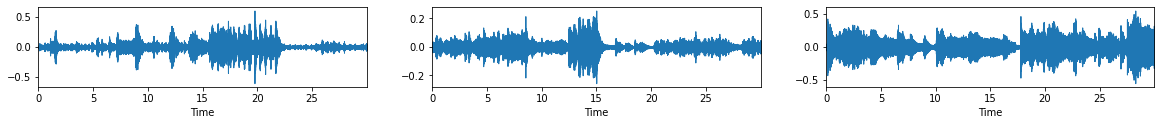

In [ ]:
plt.figure(figsize=(20, 5))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    j = load(TrackSet[i])
    librosa.display.waveplot(j[0], sr=3000)
#time-amplitude

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((TrackSet)).map(map_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

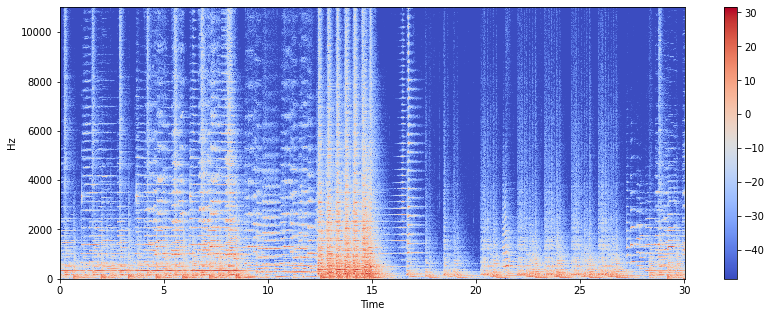

In [ ]:
# spectrogram 短时傅里叶变换
X = librosa.stft(sample_)
Xdb = librosa.amplitude_to_db(abs(X))   # 把幅度转成分贝格式
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
#横轴是时间，纵轴是频率，颜色则代表分贝（声音的响度），越红的地方信号音量越大

过零率（Zero Crossing Rate）

In [ ]:
zero_crossings = librosa.zero_crossings(sample_, pad=False)
print(sum(zero_crossings))

39308


In [ ]:
zero_crossings.mean()

0.05939612628703192

频谱中心（Spectral Centroid）

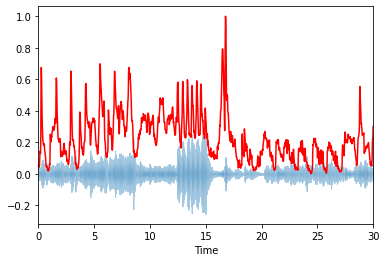

In [ ]:
#spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound

spectral_centroids = librosa.feature.spectral_centroid(sample_, sr=sr)[0]
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames, sr=sr)
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(sample_, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

频谱滚降点（Spectral Rolloff）

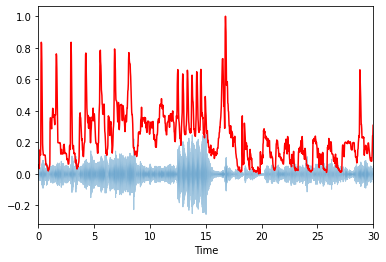

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(sample_, sr=sr)[0]
librosa.display.waveplot(sample_, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

MFCC (梅尔频率倒谱系数)

(20, 1293)


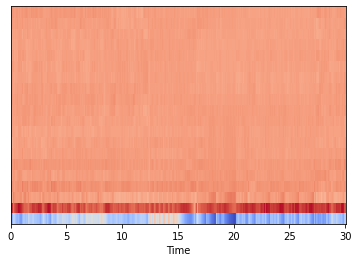

In [ ]:
mfccs = librosa.feature.mfcc(sample_, sr=sr)
print(mfccs.shape)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

# 30 seconds

In [ ]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
data_set = []
label_set = []
label2id = {genre:i for i,genre in enumerate(genres)}
id2label = {i:genre for i,genre in enumerate(genres)}

In [ ]:
label2id

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [ ]:
header = 'filename length chroma_stft_mean chroma_stft_var rmse_mean rmse_var spectral_centroid_mean spectral_centroid_var spectral_bandwidth_mean spectral_bandwidth_var rolloff_mean rolloff_var zero_crossing_rate_mean zero_crossing_rate_var harmony_mean harmony_var perceptrual_mean perceptrual_var tempo'
for i in range(1, 21):
    header += f' mfcc{i}_mean'
    header += f' mfcc{i}_var'
header += ' label'
header = header.split()

In [ ]:
file = open('/content/drive/My Drive/Colab Notebooks/5001/features_30_sec.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

In [ ]:
for g in genres:
  print(g)
  for filename in os.listdir(f'/content/drive/My Drive/Colab Notebooks/5001/Data/genres_original/{g}/'):
    songname = f'/content/drive/My Drive/Colab Notebooks/5001/Data/genres_original/{g}/{filename}'
    y, sr = librosa.load(songname)
    #修剪音频信号的前导和尾随静音
    y, _ = librosa.effects.trim(y)
    length = len(y)
    #使用chroma_stft, rmse, spec_cent, spec_bw, rolloff, zcr, harmony, perceptrual, tempo九个特征，再加上mfcc的20个特征的均值和方差
    chroma_stft = librosa.feature.chroma_stft(y=y)
    rmse = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    harm, perc = librosa.effects.hpss(y)
    tempo, _ = librosa.beat.beat_track(y, sr = sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    to_append = f'{filename} {length} {chroma_stft.mean()} {chroma_stft.var()} {rmse.mean()} {rmse.var()} {spec_cent.mean()} {spec_cent.var()} {spec_bw.mean()} {spec_bw.var()} {rolloff.mean()} {rolloff.var()} {zcr.mean()} {zcr.var()} {harm.mean()} {harm.var()} {perc.mean()} {perc.var()} {tempo}'    
    for e in mfcc:
        to_append += f' {e.mean()}'
        to_append += f' {e.var()}'
    to_append += f' {g}'
    file = open('/content/drive/My Drive/Colab Notebooks/5001/features_30_sec.csv', 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())

blues
classical
country
disco
hiphop
jazz
metal
pop
reggae
rock


In [ ]:
# jazz54 损坏文件
# y, sr = librosa.load('/content/drive/My Drive/Colab Notebooks/5001/Data/genres_original/jazz/jazz.00054.wav', mono=True, duration=30)

In [ ]:

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/5001/features_30_sec.csv')
data

,filename,length,chroma_stft_mean,chroma_stft_var,rmse_mean,rmse_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptrual_mean,perceptrual_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00086.wav,661794,0.365861,0.096413,0.124957,0.003670,1245.730096,713244.108470,1634.668746,335261.334729,2518.210681,3.531521e+06,0.048819,0.002727,-1.147909e-05,0.011523,-0.000057,0.002918,123.046875,-212.762214,7250.650321,139.049727,1555.384544,9.453369,731.735857,35.447540,257.889328,12.706967,310.916888,20.415394,185.938689,-5.578320,180.189569,10.880581,102.240537,-8.735505,140.555652,8.058369,75.937900,0.168200,95.164629,2.646515,75.560544,-1.029334,76.206668,-1.410166,72.713743,-4.707690,72.962792,1.135822,100.192855,-9.466161,81.013953,-2.184865,54.670412,-4.101649,52.215636,-3.349185,45.726935,blues
1,blues.00051.wav,661794,0.393688,0.085242,0.196676,0.001704,1977.234251,137042.544421,1928.108818,73970.446671,3943.448931,6.957120e+05,0.106602,0.000946,1.718183e-06,0.018109,-0.000052,0.009175,99.384014,-55.607545,1011.334261,114.931618,317.622993,-37.031946,206.953978,64.889500,69.233900,-7.141715,94.649490,15.237941,115.248854,-16.232676,98.287484,18.631574,78.210333,-9.752268,68.453757,21.454282,73.529962,-5.648910,72.108124,12.788084,99.353408,-16.530477,55.946201,3.792918,54.182318,-7.900901,58.026654,8.470492,56.294113,-4.071422,47.105082,3.203313,50.161633,-5.184596,54.769468,-1.279901,57.965286,blues
2,blues.00045.wav,661794,0.429437,0.089978,0.148358,0.000708,1739.134033,144924.347154,2290.407132,65373.920105,4551.141570,8.197016e+05,0.048048,0.000266,-2.086361e-03,0.013827,-0.004862,0.002336,129.199219,-163.216766,667.592175,89.778844,207.692984,12.976253,134.920785,80.702302,43.427720,3.665381,32.862153,39.738741,38.837747,-5.406734,43.896499,26.493731,31.593061,-13.169927,38.016196,2.704877,35.938966,-20.550135,38.896207,6.014822,37.785069,-2.903659,50.248042,-0.428330,32.015496,-17.539125,38.876514,4.164018,32.082261,-5.987196,36.041592,-7.864174,32.003649,-8.569909,31.848199,1.854271,42.814878,blues
3,blues.00079.wav,661794,0.421435,0.078718,0.270942,0.001899,2442.871410,130742.025014,2358.615038,31688.839901,5267.699289,4.145374e+05,0.124682,0.001189,1.108228e-05,0.040074,-0.000017,0.012179,78.302557,-3.554832,1022.766732,92.920883,171.852266,-25.078385,149.233628,45.174668,65.831389,-10.851961,70.531963,31.862459,42.623636,-18.039075,72.597707,28.624465,48.494054,-10.219610,58.847924,14.666829,41.754982,-14.900480,30.268644,14.735522,28.756872,-15.599456,41.003746,9.548925,42.884156,-14.786190,35.450273,2.065988,46.927685,-13.809604,38.263351,3.567072,33.319925,-5.962289,34.358113,-1.646955,59.907154,blues
4,blues.00078.wav,661794,0.414176,0.082947,0.258118,0.002731,2333.510454,89815.187631,2227.399756,30622.900032,4942.594552,4.815940e+05,0.123820,0.000559,9.069782e-06,0.027136,0.001124,0.015639,123.046875,-2.510370,733.091965,101.255320,164.139133,-33.922626,142.600644,41.525251,99.792209,-13.803004,105.812571,31.917940,48.275751,-21.868831,66.739952,24.465660,42.912616,-15.869253,40.967867,15.800549,33.098067,-14.362424,44.059638,12.509907,41.054342,-13.368966,39.460464,6.117490,31.854424,-9.056481,35.552732,5.043136,24.135131,-11.329323,35.154311,3.169690,30.422006,-4.570640,46.818356,-4.037942,35.260657,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
# file = open('/content/drive/My Drive/Colab Notebooks/5001/data3.csv', 'w', newline='')
# with file:
#     writer = csv.writer(file)
#     writer.writerow(header)

In [ ]:

# for g in genres:
#   print(g)
#   for filename in os.listdir(f'/content/drive/My Drive/Colab Notebooks/5001/Data/genres_original/{g}/'):
#     songname = f'/content/drive/My Drive/Colab Notebooks/5001/Data/genres_original/{g}/{filename}'
#     y, sr = librosa.load(songname)
#     length = len(y)
#     cut = math.floor(length/10)
#     #前九个
#     for i in range(9):
#       #使用chroma_stft, rmse, spec_cent, spec_bw, rolloff, zcr, harmony, perceptrual, tempo九个特征，再加上mfcc的20个特征的均值和方差
#       chroma_stft = librosa.feature.chroma_stft(y=y[cut*i:cut*(i+1)])
#       rmse = librosa.feature.rms(y=y[cut*i:cut*(i+1)])
#       spec_cent = librosa.feature.spectral_centroid(y=y[cut*i:cut*(i+1)])
#       spec_bw = librosa.feature.spectral_bandwidth(y=y[cut*i:cut*(i+1)])
#       rolloff = librosa.feature.spectral_rolloff(y=y[cut*i:cut*(i+1)])
#       zcr = librosa.feature.zero_crossing_rate(y[cut*i:cut*(i+1)])
#       harm, perc = librosa.effects.hpss(y[cut*i:cut*(i+1)])
#       tempo, _ = librosa.beat.beat_track(y[cut*i:cut*(i+1)])
#       mfcc = librosa.feature.mfcc(y=y[cut*i:cut*(i+1)])
#       names = filename.split('.')
#       to_append = f'{names[0]}.{names[1]}.{i}.wav {cut} {chroma_stft.mean()} {chroma_stft.var()} {rmse.mean()} {rmse.var()} {spec_cent.mean()} {spec_cent.var()} {spec_bw.mean()} {spec_bw.var()} {rolloff.mean()} {rolloff.var()} {zcr.mean()} {zcr.var()} {harm.mean()} {harm.var()} {perc.mean()} {perc.var()} {tempo}'    
#       for e in mfcc:
#           to_append += f' {e.mean()}'
#           to_append += f' {e.var()}'
#       to_append += f' {g}'
#       file = open('/content/drive/My Drive/Colab Notebooks/5001/data3.csv', 'a', newline='')
#       with file:
#           writer = csv.writer(file)
#           writer.writerow(to_append.split())

#     #最后一个音频
#     chroma_stft = librosa.feature.chroma_stft(y=y[cut*9:], sr=sr)
#     rmse = librosa.feature.rms(y=y[cut*9:])
#     spec_cent = librosa.feature.spectral_centroid(y=y[cut*9:], sr=sr)
#     spec_bw = librosa.feature.spectral_bandwidth(y=y[cut*9:], sr=sr)
#     rolloff = librosa.feature.spectral_rolloff(y=y[cut*9:], sr=sr)
#     zcr = librosa.feature.zero_crossing_rate(y[cut*9:])
#     harm, perc = librosa.effects.hpss(y[cut*9:])
#     tempo, _ = librosa.beat.beat_track(y[cut*9:], sr = sr)
#     mfcc = librosa.feature.mfcc(y=y[cut*9:], sr=sr)
#     names = filename.split('.')
#     to_append = f'{names[0]}.{names[1]}.{9}.wav {length-cut*9} {chroma_stft.mean()} {chroma_stft.var()} {rmse.mean()} {rmse.var()} {spec_cent.mean()} {spec_cent.var()} {spec_bw.mean()} {spec_bw.var()} {rolloff.mean()} {rolloff.var()} {zcr.mean()} {zcr.var()} {harm.mean()} {harm.var()} {perc.mean()} {perc.var()} {tempo.mean()}'    
#     for e in mfcc:
#         to_append += f' {e.mean()}'
#         to_append += f' {e.var()}'
#     to_append += f' {g}'
#     file = open('/content/drive/My Drive/Colab Notebooks/5001/data3.csv', 'a', newline='')
#     with file:
#         writer = csv.writer(file)
#         writer.writerow(to_append.split())

blues
classical
country
disco
hiphop
jazz
metal
pop
reggae
rock


In [ ]:
df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/5001/Data/features_30_sec.csv')
df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/5001/Data/features_3_sec.csv')
df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,0.081851,0.000558,-0.000078,0.008354,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.045410,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,0.087173,0.001030,-0.000099,0.004950,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145000,40.662876,-7.717751,30.808521,8.397150,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,0.071383,0.000425,-0.000066,0.012476,0.000065,0.004357,123.046875,-132.441940,3798.532227,115.085175,257.321289,-14.811666,192.448074,50.189293,144.166031,-0.680819,128.376892,24.650375,66.371170,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.991465,47.911613,11.853963,36.569931,-4.677677,40.725075,6.571110,30.686846,-2.424750,50.313499,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,0.069426,0.000304,-0.000014,0.008318,0.000018,0.005927,123.046875,-118.231087,2508.781006,132.116501,332.650574,-18.758335,109.357529,39.769306,184.693344,-13.260426,144.398224,20.468134,122.516464,-14.563448,68.937332,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.362739,60.714748,9.156193,40.411537,-9.889441,44.666325,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,0.070095,0.000289,0.000041,0.009634,-0.000106,0.005833,123.046875,-105.968376,2118.919922,134.643646,219.562622,-19.961748,171.878754,40.171753,103.120712,-14.271939,102.651230,18.734617,79.070000,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.792194,55.030254,17.045437,43.229939,-5.681399,46.515259,5.705521,24.956211,-7.986080,39.816933,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

# 3 seconds

In [ ]:
file = open('/content/drive/My Drive/Colab Notebooks/5001/features_3_sec.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

In [ ]:
for g in genres:
  print(g)
  for filename in os.listdir(f'/content/drive/My Drive/Colab Notebooks/5001/Data/cut_file/{g}/'):
    songname = f'/content/drive/My Drive/Colab Notebooks/5001/Data/cut_file/{g}/{filename}'
    y, sr = librosa.load(songname)
    y, _ = librosa.effects.trim(y)
    length = len(y)
    #使用chroma_stft, rmse, spec_cent, spec_bw, rolloff, zcr, harmony, perceptrual, tempo九个特征，再加上mfcc的20个特征的均值和方差
    chroma_stft = librosa.feature.chroma_stft(y=y)
    rmse = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    harm, perc = librosa.effects.hpss(y)
    tempo, _ = librosa.beat.beat_track(y, sr = sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    to_append = f'{filename} {length} {chroma_stft.mean()} {chroma_stft.var()} {rmse.mean()} {rmse.var()} {spec_cent.mean()} {spec_cent.var()} {spec_bw.mean()} {spec_bw.var()} {rolloff.mean()} {rolloff.var()} {zcr.mean()} {zcr.var()} {harm.mean()} {harm.var()} {perc.mean()} {perc.var()} {tempo}'    
    for e in mfcc:
        to_append += f' {e.mean()}'
        to_append += f' {e.var()}'
    to_append += f' {g}'
    file = open('/content/drive/My Drive/Colab Notebooks/5001/features_3_sec.csv', 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())

blues
classical
country
disco
hiphop
jazz
metal
pop
reggae
rock
